In [299]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2

In [300]:
plt.rcParams['figure.figsize'] = [6, 8]

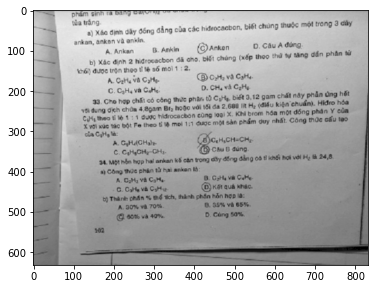

In [301]:
# Chuyển thành ảnh xám
img = cv2.imread('exam.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

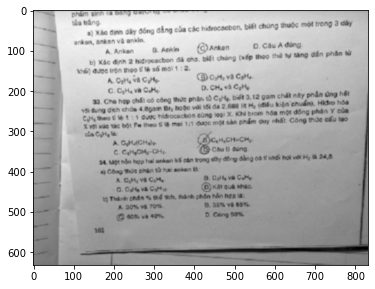

In [302]:
blurred = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

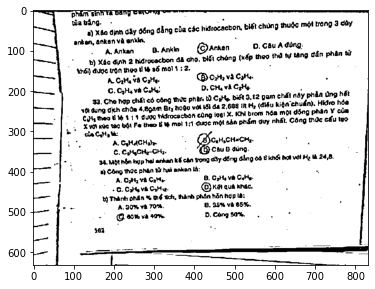

In [303]:
# Chuyển thành ảnh đen trắng bằng Gaussian Threshold 
# (với những phép toán như tìm contour hoặc binary_fill_holes sẽ xử lý hiệu quả hơn trên ảnh đen trắng nên cần có bước này)
im = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
plt.imshow(im, cmap='gray')

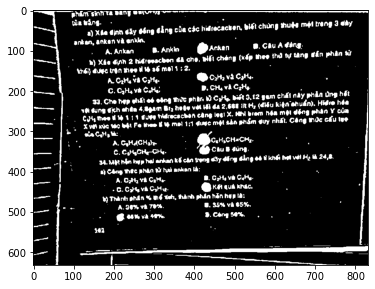

In [304]:
# lấp chỗ trống trong những hình tròn
from scipy.ndimage.morphology import binary_fill_holes

# binary_fill_holes là 1 hàm binary delation
clean_image = binary_fill_holes(255 - im)
plt.imshow(clean_image, cmap='gray')

In [305]:
clean_image = np.float32(clean_image)

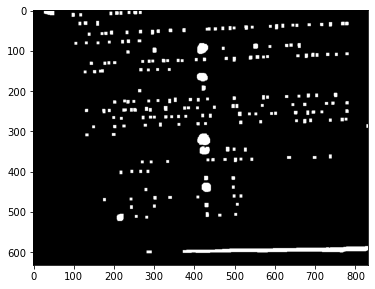

In [306]:
# Opening (mục đích để loại bỏ trường hợp 2 hình tròn dính nhau, hoặc hình tròn dính vào chữ, 
# tuy nhiên opening làm mất dấu khi các hình tròn bị gạch chéo)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
opening = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

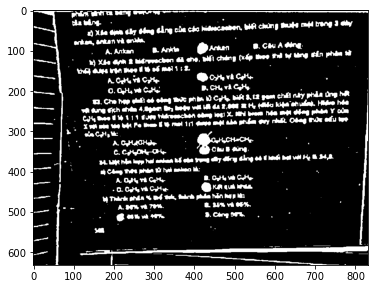

In [307]:
# Closing (thử cho vui thôi, không hiệu quả)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
closing = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

In [308]:
# Lấy ra vị trí các contour (contour là 1 chuỗi tọa độ (x_i, y_) các điểm có cùng độ sáng dọc theo biên của 1 object (t đang hiểu là thế))
contours, _ = cv2.findContours(opening.astype(np.uint8), # pylint: disable=unused-variable
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_NONE)

# Vẽ contour
obj_image = np.zeros(opening.shape)
for index, cnt in enumerate(contours):
    print(cnt.shape)
    print(cnt)
    cv2.drawContours(opening, [cnt], 0, 255, -1)

(36, 1, 2)
[[[282 596]]

 [[282 597]]

 [[282 598]]

 [[282 599]]

 [[282 600]]

 [[282 601]]

 [[282 602]]

 [[283 602]]

 [[284 602]]

 [[285 602]]

 [[286 602]]

 [[287 602]]

 [[288 602]]

 [[289 602]]

 [[290 602]]

 [[291 602]]

 [[292 602]]

 [[293 602]]

 [[294 602]]

 [[294 601]]

 [[294 600]]

 [[294 599]]

 [[294 598]]

 [[294 597]]

 [[294 596]]

 [[293 596]]

 [[292 596]]

 [[291 596]]

 [[290 596]]

 [[289 596]]

 [[288 596]]

 [[287 596]]

 [[286 596]]

 [[285 596]]

 [[284 596]]

 [[283 596]]]
(933, 1, 2)
[[[825 585]]

 [[824 586]]

 [[823 586]]

 ...

 [[828 585]]

 [[827 585]]

 [[826 585]]]
(24, 1, 2)
[[[279 510]]

 [[279 511]]

 [[279 512]]

 [[279 513]]

 [[279 514]]

 [[279 515]]

 [[279 516]]

 [[280 516]]

 [[281 516]]

 [[282 516]]

 [[283 516]]

 [[284 516]]

 [[285 516]]

 [[285 515]]

 [[285 514]]

 [[285 513]]

 [[285 512]]

 [[285 511]]

 [[285 510]]

 [[284 510]]

 [[283 510]]

 [[282 510]]

 [[281 510]]

 [[280 510]]]
(24, 1, 2)
[[[253 508]]

 [[253 509]

Ta có công thức $\frac{4\pi^2r^2}{C^2}=1$ trong đó $C$ là chu vi của hình tròn, giờ ta xác định giá trị $\alpha=\frac{4\pi area}{P^2}$ với $P$ là chu vi của `contour` và nếu giá trị $\alpha$ lớn hơn hoặc bằng `round_thresh` thì ta chấp nhận `contour` đấy là vòng tròn. Ngoài ra trong ảnh các chữ cái cũng có thể tạo thành contour với `area` nhỏ, nên cần phải có một `threshold` nữa cho `area`

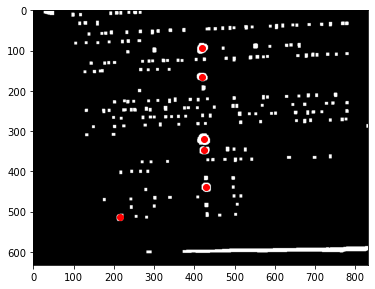

In [313]:
import matplotlib.pyplot as plt

round_thresh = 0.6

plt.figure()
height, width = obj_image.shape
plt.imshow(opening.astype(np.uint8), cmap='gray')
areas = []
alphas = []

# print('Object      Area Perimeter Roundness')
for ind, contour in enumerate(contours):
    # tính chu vi của contour
    perimeter = cv2.arcLength(contour, True)
    # tính diện tích của contour
    area = cv2.contourArea(contour)
    areas.append(area)
    
    # nếu như chu vi bằng 0 hoặc area nhỏ hơn threshold thì ta đặt ngay góc alpha = 0
    if perimeter==0 or area<150:
        alpha = 0
    else:
        alpha = 4*np.pi*area/(perimeter**2)
        alphas.append(alpha)

    # Vẽ vòng tròn đỏ tại tâm của contour thỏa mãn điều kiện là vòng tròn
    if alpha > round_thresh:
        moments = cv2.moments(contour)
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        plt.plot(cx, cy, 'ro')

axes = plt.gca()
axes.set_xlim([0, width])
axes.set_ylim([height, 0])

plt.show()

In [314]:
n = 6
  
alphas.sort()
areas.sort() 
print(areas[-n:]) 
print(alphas[-n:])

[391.0, 425.0, 430.5, 544.0, 702.0, 4007.5]
[0.7558247897058563, 0.8263133474798106, 0.8352530103555198, 0.8450689278640103, 0.8516926426502268, 0.8902057935093347]
